In [52]:
import numpy as np
import sklearn
import pandas as pd 
import matplotlib.pyplot as plt
import imblearn
import time
import tensorflow as tf
import tensorflow.keras as keras
import os

### Decorator to measure training time

In [21]:
def timeit(method): # Decorator to measure running time
    def timed(*args, **kwargs):
        start = time.time()
        result = method(*args, **kwargs)
        end = time.time()
        return result, round((end - start), 4)
    return timed

# Dataset

In [2]:
facial_data = np.load('2039045/2039045_face.npz')
facial_data.files

['X_train', 'y_train', 'X_valid', 'y_valid', 'X_test', 'y_test']

In [3]:
X_train = facial_data['X_train']
y_train = facial_data['y_train']
X_valid = facial_data['X_valid']
y_valid = facial_data['y_valid']
X_test = facial_data['X_test']
y_test = facial_data['y_test']

# Exploratory data analysis tasks

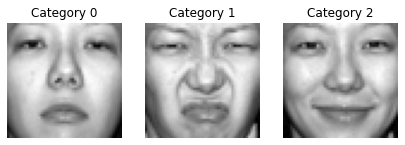

In [4]:
cat_index = dict()
fig_01, ax = plt.subplots(1, 3, figsize = (7, 7))
for i in range(len(np.unique(y_train))):
    cat_index[i] = np.where(y_train == i)[0] # Finding out which indexes belong to each label
    imag = X_train[cat_index[i][0]].reshape((48, 48))
    ax[i].imshow(imag, cmap = 'gray')
    ax[i].set_title(f'Category {i}')
    ax[i].axis('off')
plt.show()

In [5]:
#Combining the target labels
y = np.concatenate((y_train, y_valid, y_test)) 

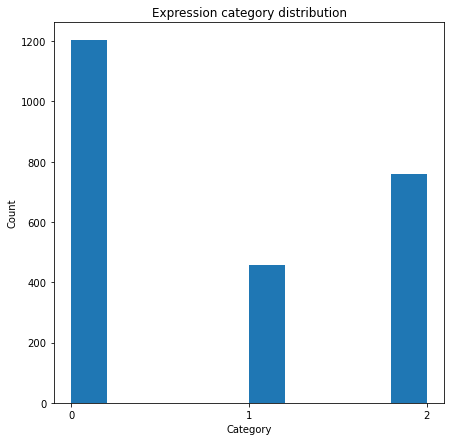

'The data is not balanced'

In [6]:
fig_02, ax = plt.subplots(1, 1, figsize = (7, 7))
ax.hist(y)
ax.set_xticks([0, 1, 2])
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_title('Expression category distribution')
plt.show()
"""The data is not balanced"""

# Classification tasks

## 1.3.1

training time:  0.001542806625366211
KNN (k = 1) accuracy on test set: 0.7831858407079646


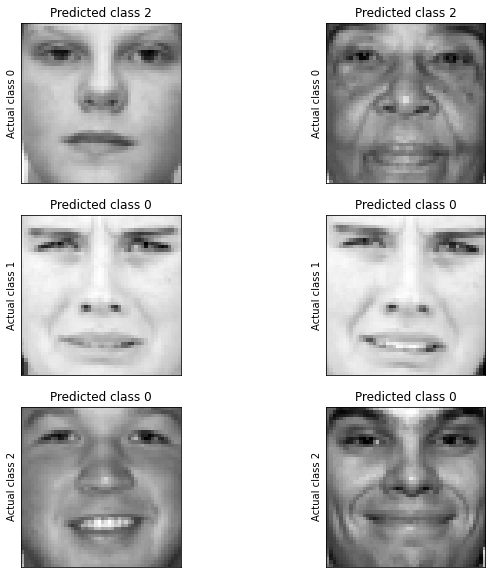

KNN (k = 1) classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       122
           1       0.68      0.42      0.52        40
           2       0.84      0.73      0.78        64

    accuracy                           0.78       226
   macro avg       0.77      0.70      0.72       226
weighted avg       0.78      0.78      0.77       226



In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import time

# Train KNN with k = 1
start = time.time()
knn_clf = KNeighborsClassifier(n_neighbors = 1, weights = 'uniform')
knn_clf.fit(X_train, y_train)
end = time.time()
time_taken = end - start
print('training time: ', time_taken)

#Calculating accuracy for test set
knn_acc_test = knn_clf.score(X_test, y_test)
print(f'KNN (k = 1) accuracy on test set: {knn_acc_test}')

#Displaying two mis-classified images for each class
y_pred_knn_test = knn_clf.predict(X_test)

mis_classified_index = np.where((y_pred_knn_test == y_test) == False)

fig_03, ax = plt.subplots(3, 2, figsize = (10, 10))
for i in range(3):
    imgs = np.zeros((2, 48, 48))
    count = 0
    for mis_index in mis_classified_index[0]:
        if count == 2:
            break
        if (y_test[mis_index] == i):
            imgs[count] = X_test[mis_index].reshape((48, 48))
            ax[i, count].imshow(imgs[count], cmap = 'gray')
            ax[i, count].set_ylabel(f'Actual class {i}')
            ax[i, count].set_title(f'Predicted class {y_pred_knn_test[mis_index]}')
            ax[i, count].tick_params(axis = 'x', which = 'both', bottom = False, labelbottom = False)
            ax[i, count].tick_params(axis = 'y', which = 'both', left = False, labelleft = False)
            count += 1
            
plt.show()

# Providing other metrics
knn_report_test = classification_report(y_test, y_pred_knn_test)
print('KNN (k = 1) classification report')
print(50 * '-')
print(knn_report_test)

## 1.3.2

In [8]:
# I will find the best number of neighbors
knn_acc_arr = [0]
for i in np.arange(1, 21):
    knn_clf_search = KNeighborsClassifier(n_neighbors = i, weights = 'uniform')
    knn_clf_search.fit(X_train, y_train)
    knn_acc_arr.append(knn_clf_search.score(X_test, y_test))

knn_acc_arr = np.array(knn_acc_arr)
best_k = np.argmax(knn_acc_arr)
print(f'Best number of neighbors: {best_k}')

Best number of neighbors: 3


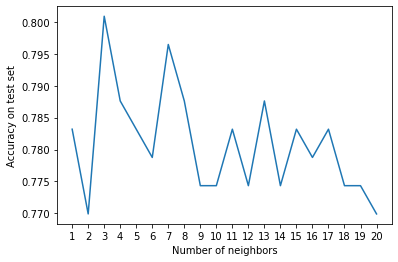

In [9]:
fig_04, ax = plt.subplots()
ax.plot(knn_acc_arr[1:])
ax.set_xticks(np.arange(0, 20))
ax.set_xticklabels(list(np.arange(1, 21)))
ax.set_xlabel('Number of neighbors')
ax.set_ylabel('Accuracy on test set')
plt.show()

## 1.3.3

In [10]:
X_train.shape, y.shape

((1946, 2304), (2417,))

In [11]:
print(np.bincount(y_train), np.bincount(y_valid), np.bincount(y_test))

[963 372 611] [117  45  83] [122  40  64]


### Balancing the dataset

In [12]:
from imblearn.over_sampling import RandomOverSampler

over_sample = RandomOverSampler(sampling_strategy = 'not majority')

In [13]:
X_train_oversample, y_train_oversample = over_sample.fit_resample(X_train, y_train)
print(X_train_oversample.shape, np.bincount(y_train_oversample))

(2889, 2304) [963 963 963]


## Training and evaluating models

### Class and function to find the best hyperparameters

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
class OptimizingParamaters(BaseEstimator, TransformerMixin): # A class which has a purpose of finding the best parameters
    def __init__(self, model, params_dict, data_transformer = None):
        self.data_transformer = data_transformer
        self.params_dict_ = params_dict
        self.model = model
        self.best_params_ = {}
        self.best_acc_ = float('-inf')
        self.best_time_ = 0
        self.best_metrics_ = {}
        self.best_yPred_ = []
    @timeit
    def model_training(self, params, X, y = None): #Training the model
        self.model.set_params(**params)
        self.model.fit(X, y)
    def fit(self, X, y = None):
        if (self.data_transformer is not None):
            X_valid_transformed = self.data_transformer.transform(X_valid)
        else:
            X_valid_transformed = X_valid
        for combination in list(ParameterGrid(self.params_dict_)): # Running through every combination of parameters
            _, computation_time = self.model_training(combination, X, y)
            y_pred = self.predict(X_valid_transformed)
            acc = accuracy_score(y_valid, y_pred)
            if acc > self.best_acc_:
                self.best_acc_ = acc
                self.best_params_ = combination
                self.best_time_ = computation_time
                self.best_yPred_ = list(y_pred)
        self.best_metrics_ = classification_report(y_valid, self.best_yPred_, output_dict = True)
    def transform(self, X):
        pass
    def predict(self, X):
        return self.model.predict(X)
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    def score(self, X, y):
        return self.model.score(X, y)
    

In [28]:
def full_pipeline(X_train, y_train, X_test, y_test, model, param_grid, data_transformer = None):
    if data_transformer is not None:
        #try:
            #X_train_transformed = data_transformer.fit_transform(X_train)
            #X_test_transformed = data_transformer.transform(X_test)
        #except ValueError:
        X_train_transformed = data_transformer.fit_transform(X_train, y_train)
        X_test_transformed = data_transformer.transform(X_test)
    else:
        X_train_transformed = X_train
        X_test_transformed = X_test
    # Finding the best hyperparameters
    hyperpara_optimizer = OptimizingParamaters(model, param_grid, data_transformer)
    hyperpara_optimizer.fit(X_train_transformed, y_train)
    best_params = hyperpara_optimizer.best_params_
    best_time = hyperpara_optimizer.best_time_
    
    # Metrics tested on test set
    best_model = model.set_params(**hyperpara_optimizer.best_params_)
    best_model.fit(X_train_transformed, y_train)
    y_pred = best_model.predict(X_test_transformed)
    test_metrics = classification_report(y_test, y_pred, output_dict = True)
    
    # Extract accuracy, macro-avg precison, recall, and F1 score. I use [:-1] because I don't want to extract support
    important_metrics = [test_metrics['accuracy'], *test_metrics['macro avg'].values()][:-1] 
    important_metrics.insert(0, best_time) 
    
    # [time, accuracy, macro-avg precision, recall, F1] and a best hyperparameters dict
    return important_metrics, best_params 
    

### Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
from itertools import chain

log_clf = LogisticRegression(random_state = 42, max_iter = 1000)
log_grid = {'C': list(chain.from_iterable((0.001 * (10 ** i), 0.005 * (10 ** i)) for i in range(6)))}
pca = PCA(n_components = 0.95) # I want to preserve 95% of the training set variance

log_metrics, log_params = full_pipeline(X_train = X_train_oversample, 
                                         y_train = y_train_oversample,
                                         X_test = X_test,
                                         y_test = y_test,
                                         model = log_clf,
                                         param_grid = log_grid,
                                         data_transformer = pca)


test metrics:  {'0': {'precision': 0.9016393442622951, 'recall': 0.9016393442622951, 'f1-score': 0.9016393442622952, 'support': 122}, '1': {'precision': 0.75, 'recall': 0.825, 'f1-score': 0.7857142857142856, 'support': 40}, '2': {'precision': 0.8833333333333333, 'recall': 0.828125, 'f1-score': 0.8548387096774193, 'support': 64}, 'accuracy': 0.8672566371681416, 'macro avg': {'precision': 0.8449908925318761, 'recall': 0.8515881147540983, 'f1-score': 0.8473974465513333, 'support': 226}, 'weighted avg': {'precision': 0.8696165191740413, 'recall': 0.8672566371681416, 'f1-score': 0.867868357734187, 'support': 226}}
[0.8672566371681416, 0.8449908925318761, 0.8515881147540983, 0.8473974465513333]
[0.8015, 0.8672566371681416, 0.8449908925318761, 0.8515881147540983, 0.8473974465513333]
----------------------------------------
{'C': 0.001}


In [ ]:
print(log_metrics)
print(40 * '-')
print(log_params)

### Decision Trees with Gradient Boosting 

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier


gb_clf = GradientBoostingClassifier(n_estimators = 100, max_depth = 3, learning_rate = 0.1)
gb_grid = {'max_depth': list(range(1, 6)), 'max_features' : [None, 'sqrt', 'log2', 0.3]}
select_rndForests = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state=42), 
                                    threshold = 'median') # Using random forests to choose the best features
gb_metrics, gb_params = full_pipeline(X_train = X_train_oversample, 
                                     y_train = y_train_oversample,
                                     X_test = X_test,
                                     y_test = y_test,
                                     model = gb_clf,
                                     param_grid = gb_grid,
                                     data_transformer = select_rndForests)

test metrics:  {'0': {'precision': 0.9047619047619048, 'recall': 0.9344262295081968, 'f1-score': 0.9193548387096775, 'support': 122}, '1': {'precision': 0.7560975609756098, 'recall': 0.775, 'f1-score': 0.7654320987654322, 'support': 40}, '2': {'precision': 0.9661016949152542, 'recall': 0.890625, 'f1-score': 0.9268292682926829, 'support': 64}, 'accuracy': 0.8938053097345132, 'macro avg': {'precision': 0.8756537202175897, 'recall': 0.866683743169399, 'f1-score': 0.870538735255931, 'support': 226}, 'weighted avg': {'precision': 0.8958201915688189, 'recall': 0.8938053097345132, 'f1-score': 0.894228528512963, 'support': 226}}
[0.8938053097345132, 0.8756537202175897, 0.866683743169399, 0.870538735255931]


In [29]:
print(gb_metrics)
print(40 * '-')
print(gb_params)

[5.8852, 0.8938053097345132, 0.8756537202175897, 0.866683743169399, 0.870538735255931]
----------------------------------------
{'max_depth': 4, 'max_features': 'sqrt'}


### SVM

In [30]:
from sklearn.svm import SVC
from itertools import chain

svc_clf = SVC(random_state = 42)
svc_grid = {'C': [0.001 * (10 ** i) for i in range(6)], 
           'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10]}
pca = PCA(n_components = 0.95) # I want to preserve 95% of the training set variance

svc_metrics, svc_params = full_pipeline(X_train = X_train_oversample, 
                                         y_train = y_train_oversample,
                                         X_test = X_test,
                                         y_test = y_test,
                                         model = svc_clf,
                                         param_grid = svc_grid,
                                         data_transformer = pca)

In [31]:
print(svc_metrics)
print(40 * '-')
print(svc_params)

[0.1618, 0.911504424778761, 0.9012648305839598, 0.8744877049180327, 0.8859422605569985]
----------------------------------------
{'C': 10.0, 'gamma': 'scale'}


### Voting classifier

In [42]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators = [('lr', log_clf), ('gb', gb_clf), ('svc', svc_clf)], 
                              voting = 'hard',
                             n_jobs = -1)
voting_grid = {}
pca = PCA(n_components = 0.95)

voting_metrics, voting_params = full_pipeline(X_train = X_train_oversample, 
                                         y_train = y_train_oversample,
                                         X_test = X_test,
                                         y_test = y_test,
                                         model = voting_clf,
                                         param_grid = voting_grid,
                                         data_transformer = None)

In [43]:
print(voting_metrics)
print(40 * '-')
print(voting_params)

[20.2147, 0.9247787610619469, 0.93933433607158, 0.8876366120218578, 0.9071268542695812]
----------------------------------------
{}


### Neural network

In [49]:
# Reshape each image to 48 * 48
X_train_reshaped = X_train_oversample.reshape(-1, 48, 48)
X_valid_reshaped = X_valid.reshape(-1, 48, 48)
X_test_reshaped = X_test.reshape(-1, 48, 48)
print(X_train_reshaped.shape)

(2889, 48, 48)


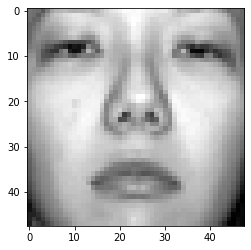

In [47]:
plt.figure()
plt.imshow(X_train_reshaped[0,...], cmap = 'gray')

In [51]:
def build_cnn_model(learning_rate = 1e-2,input_shape = [48, 48, 1]):
    # Building a CNN
    model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation = 'relu', padding = 'same', input_shape = [48, 48, 1]),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same'),
    keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same'),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same'),
    keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same'),
    keras.layers.MaxPool2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation = 'softmax')
])
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(loss = 'sparse_categorical_crossentropy', 
                  optimizer = optimizer, 
                  metrics = ['accuracy'] 
                 )
    return model

In [ ]:
cnn_clf = keras.wrappers.scikit_learn.KerasClassifier(build_cnn_model)
cnn_grid = {'learning_rate': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]}

cnn_metrics, cnn_params = full_pipeline(X_train = X_train_oversample, 
                                         y_train = y_train_oversample,
                                         X_test = X_test,
                                         y_test = y_test,
                                         model = svc_clf,
                                         param_grid = svc_grid,
                                         data_transformer = pca)

In [ ]:
print(cnn_metrics)
print(40 * '-')
print(cnn_params)

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True),
                             keras.callbacks.ModelCheckpoint('cnn_model.h5', save_best_only = True)]

# Ideas testing

In [102]:
test_df = pd.DataFrame()
b = test_df.append([[1, 2, 3]])
b

,0,1,2
0,1,2,3


In [20]:
zoo = classification_report(y_test, y_pred_knn_test, output_dict = True)
print(zoo)

{'0': {'precision': 0.7793103448275862, 'recall': 0.9262295081967213, 'f1-score': 0.8464419475655431, 'support': 122}, '1': {'precision': 0.68, 'recall': 0.425, 'f1-score': 0.5230769230769231, 'support': 40}, '2': {'precision': 0.8392857142857143, 'recall': 0.734375, 'f1-score': 0.7833333333333332, 'support': 64}, 'accuracy': 0.7831858407079646, 'macro avg': {'precision': 0.7661986863711002, 'recall': 0.6952015027322404, 'f1-score': 0.7176174013252665, 'support': 226}, 'weighted avg': {'precision': 0.7787174680674834, 'recall': 0.7831858407079646, 'f1-score': 0.7713377338911793, 'support': 226}}


In [58]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95) # I want to preserve 95% of the training set variance
X_train_pca= pca.fit_transform(X_train_oversample)
print(X_train_pca.shape)

(2889, 79)


In [66]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

log_param_dict = {'C': list(chain.from_iterable((0.001 * (10 ** i), 0.005 * (10 ** i)) for i in range(6)))}
log_hyperpara_optimizer = OptimizingParamaters(LogisticRegression(random_state = 42, max_iter = 1000), 
                                               log_param_dict, 
                                              pca)
log_hyperpara_optimizer.fit(X_train_pca, y_train_oversample)
log_best_params = log_hyperpara_optimizer.best_params_
log_best_results = log_hyperpara_optimizer.best_metrics_
log_best_time = log_hyperpara_optimizer.best_time_
log_important_metrics = [log_best_results['accuracy'], log_best_results['macro avg']]
print(log_important_metrics)
print(log_best_time)
print(log_best_params)

[0.8979591836734694, {'precision': 0.8861615245009075, 'recall': 0.8648474238835684, 'f1-score': 0.8734424418946573, 'support': 245}]
0.7799
{'C': 0.001}


In [87]:
X_test_reduced = pca.transform(X_test)
xz = classification_report(y_test, log_hyperpara_optimizer.predict(X_test_reduced))
print(xz)

              precision    recall  f1-score   support

           0       0.92      0.89      0.91       122
           1       0.76      0.88      0.81        40
           2       0.85      0.83      0.84        64

    accuracy                           0.87       226
   macro avg       0.85      0.87      0.85       226
weighted avg       0.88      0.87      0.87       226



In [83]:
[1, *log_best_results['macro avg'].values()][:-1]

[1, 0.8861615245009075, 0.8648474238835684, 0.8734424418946573]

In [21]:
from sklearn.model_selection import ParameterGrid
y = [{'a': [1, 2, 3], 'b': [4, 5, 6], 'c': [1]}, {'a': [-1, -2, -3], 'b': [-4, -5, -6], 'c': [-1]}]
list(ParameterGrid(y))

[{'a': 1, 'b': 4, 'c': 1},
 {'a': 1, 'b': 5, 'c': 1},
 {'a': 1, 'b': 6, 'c': 1},
 {'a': 2, 'b': 4, 'c': 1},
 {'a': 2, 'b': 5, 'c': 1},
 {'a': 2, 'b': 6, 'c': 1},
 {'a': 3, 'b': 4, 'c': 1},
 {'a': 3, 'b': 5, 'c': 1},
 {'a': 3, 'b': 6, 'c': 1},
 {'a': -1, 'b': -4, 'c': -1},
 {'a': -1, 'b': -5, 'c': -1},
 {'a': -1, 'b': -6, 'c': -1},
 {'a': -2, 'b': -4, 'c': -1},
 {'a': -2, 'b': -5, 'c': -1},
 {'a': -2, 'b': -6, 'c': -1},
 {'a': -3, 'b': -4, 'c': -1},
 {'a': -3, 'b': -5, 'c': -1},
 {'a': -3, 'b': -6, 'c': -1}]

In [69]:
zot = 5
class A:
    def __init__(self):
        self.x = zot
        print(self.x)
def foo():
    zot = 10
    a = A()

foo()

5
